# Fisher Information fits for 1 object (2016)

This is a redo of Figure 7 in the paper, but using the last codebase.

Need to check:

* What is the Fisher Info that was really used
* If we need T or T-1 in the theoretical thing.

Later:

* Extend this to multiple objects and redo similar plots for Thesis.


In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [117]:
import os
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.utils import io
import progress

from experimentlauncher import ExperimentLauncher
from dataio import DataIO
import plots_experimental_data
import em_circularmixture_parametrickappa


# import matplotlib.animation as plt_anim
from mpl_toolkits.mplot3d import Axes3D

import re
import inspect
import imp

import utils
import load_experimental_data

from plots_fitexperiment_papertheo import PlotsFitExperimentAllTPaperTheo

In [33]:
%cd '/nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/code/git-bayesian-visual-working-memory'

/nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/code/git-bayesian-visual-working-memory


In [74]:
arguments_dict = dict(
    action_to_do='launcher_check_fisher_fit_1obj_2016',
    collect_responses=None,
    inference_method='sample',
    N=200,
    num_samples=50,
    M=14**2,
    T=1,
    num_repetitions=3,
    renormalize_sigma=None,
#     rc_scale = 4.,
    autoset_parameters=None,
    label='thesis_fisherinfo_fit_1obj_newcodebase',
    code_type='conj',
    output_directory='./Experiments/fisherinfo_singleitem/thesisrerun_do_plot_fisher_info_fit_1obj_newcodebase_050816',
    ratio_conj=1.,
    sigmax=0.2,
    sigmay=0.000001,
    sigma_output=0.0,
    selection_num_samples=1,
    selection_method='last',
    slice_width=0.07,
    burn_samples=100,
    enforce_min_distance=0.17,
    specific_stimuli_random_centers=None,
    stimuli_generation='random',
    stimuli_generation_recall='random',
    experiment_data_dir=os.path.normpath(os.path.join(os.environ['WORKDIR_DROP'], '../../experimental_data')),
)
experiment_launcher = ExperimentLauncher(run=True, arguments_dict=arguments_dict)

Arguments: ['-f', '/run/user/5201/jupyter/kernel-cb57753c-4a10-415f-8e00-c9d335e48986.json']
None
Doing a piece of work for launcher_check_fisher_fit_1obj_2016
{'M_layer_one': 400, 'code_type': 'conj', 'verbose': False, 'selection_num_samples': 1, 'subaction': '', 'load_all_from_parameters_file': False, 'pylab': True, 'specific_stimuli_random_centers': True, 'enforce_min_distance': 0.17, 'result_computation': '', 'threshold': 0.0, 'slice_width': 0.07, 'rc_scale': 0.5, 'autoset_parameters': True, 'job_name': '', 'experiment_data_dir': '/nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/experimental_data', 'normalise_weights': 1, 'use_theoretical_cov': False, 'best_parameters_file': '', 'plot_while_running': False, 'D': 32, 'output_directory': './Experiments/fisherinfo_singleitem/thesisrerun_do_plot_fisher_info_fit_1obj_newcodebase_050816', 'R': 2, 'distribution_weights': 'exponential', 'T': 1, 'feat_ratio': 40.0, 'f': '/run/user/5201/jupyter/kernel-cb57753c-4a10-415f-

In [75]:
sampler = experiment_launcher.all_vars['sampler']

## Plots now

In [76]:
def extract_fisherinfo_values(experiment_launcher, values_to_plot):
    experiment_launcher.all_vars['mem_fidelity_as_variance'] = \
        1./utils.kappa_to_stddev(experiment_launcher.all_vars['result_em_fits'][0])**2.

    result_dict = dict(mean=[], std=[], names=[])
    for value_name, value_result in values_to_plot:
        result_dict['names'].append(value_name)
        result_dict['mean'].append(utils.nanmean(experiment_launcher.all_vars[value_result]))
        result_dict['std'].append(utils.nanstd(experiment_launcher.all_vars[value_result]))

    result_dict['mean'] = np.array(result_dict['mean'])
    result_dict['std'] = np.array(result_dict['std'])
    
    return result_dict

def bars_fisherinfo_comparison(values_bars, values_bars_std, values_names, ax=None):
    color_gen = sns.color_palette(palette='muted', n_colors=len(values_bars))
    # set_colormap = plt.cm.cubehelix
    # color_gen = [set_colormap((i+0.1)/(float(np.max((5, len(values_bars)))+0.1))) for i in xrange(np.max((5, len(values_bars))))][::-1]

    bars_indices = np.arange(values_bars.size)
    width = 0.7

    ## Plot all as bars
    if ax is None:
        f, ax = plt.subplots(figsize=(10,6))

    for bar_i in xrange(values_bars.size):
        ax.bar(bars_indices[bar_i], values_bars[bar_i], width=width, color=color_gen[bar_i], zorder=2)
        ax.errorbar(bars_indices[bar_i] + width/2., 
                     values_bars[bar_i], 
                     yerr=values_bars_std[bar_i], 
                     ecolor='k', 
                     capsize=20, capthick=2, linewidth=2, zorder=3)

    # Add the memory fidelity multiplied by 2
    ax.bar(bars_indices[0], 
            2*values_bars[0], 
            width=width, 
            color=color_gen[0], 
            alpha=0.5, 
            hatch='/', linestyle='dashed', 
            zorder=1
           )
    ax.errorbar(bars_indices[0] + width/2., 
                 2*values_bars[0], 
                 yerr=2*values_bars_std[0], 
                 ecolor='k', 
                 alpha=0.3, 
                 capsize=20, capthick=2, 
                 linewidth=2, linestyle='--', fmt="none",
                 zorder=3
                )

    ax.set_xticks(bars_indices + width/2.)
    ax.set_xticklabels(values_names)
    ax.set_xlim((-0.2, bars_indices.size))
    plt.tight_layout()

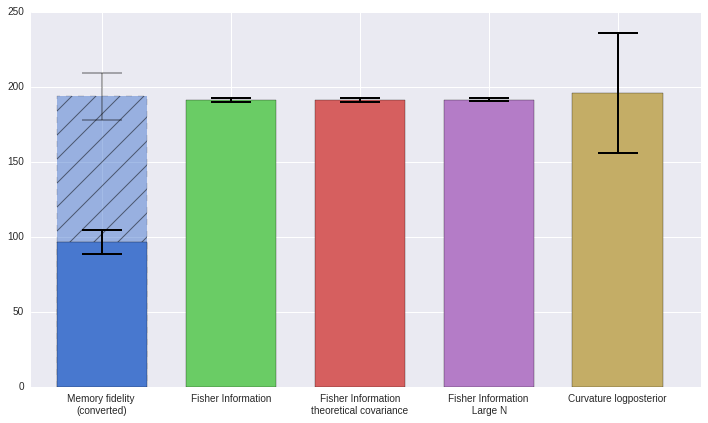

In [77]:
values_to_plot = [('Memory fidelity \n(converted)', 'mem_fidelity_as_variance'),
                  ('Fisher Information', 'result_FI_rc_theo'),
                  ('Fisher Information\ntheoretical covariance', 'result_FI_rc_theocov'),
                  ('Fisher Information\n Large N', 'result_FI_rc_theo_largeN'),
                  ('Curvature logposterior', 'result_FI_rc_curv')
               ]

values_dict = extract_fisherinfo_values(experiment_launcher, values_to_plot)

bars_fisherinfo_comparison(values_dict['mean'], values_dict['std'], values_dict['names'])

(<matplotlib.axes._subplots.AxesSubplot at 0x7f5577fbf250>,
 <matplotlib.image.AxesImage at 0x7f5577ea2610>)

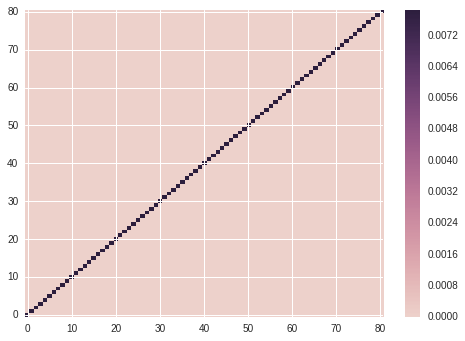

In [66]:
cmap = sns.cubehelix_palette(as_cmap=True)
utils.pcolor_2d_data(sampler.noise_covariance, cmap=cmap)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f5584021b10>,
 <matplotlib.image.AxesImage at 0x7f5577ba83d0>)

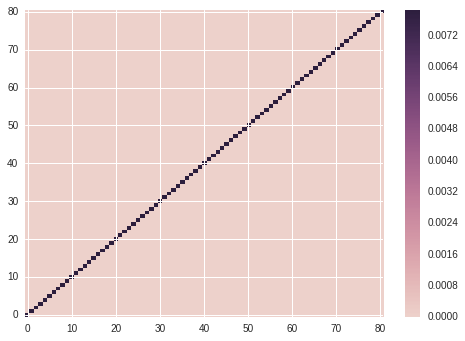

In [67]:
utils.pcolor_2d_data(sampler.compute_covariance_theoretical(), cmap=cmap)

True angles: 1.417 >> Inferred: 1.521


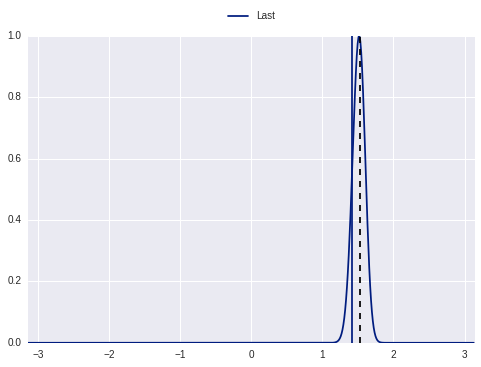

In [68]:
sns.set_palette('dark')
sampler.plot_likelihood_correctlycuedtimes(should_exponentiate=True, n=9)

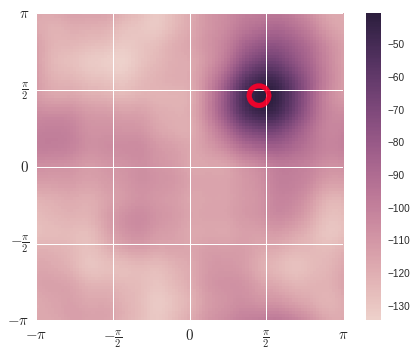

In [69]:
n=9
sampler.plot_likelihood_variation_twoangles(should_exponentiate=False, n=n, colormap=cmap)

The KL Covariance thing needs to be checked, there's an error somewhere.

Basically:

- with random stimuli, we need to take the covariance of mu(theta) into account, as we are effectively marginalising over possible items when computing Sigma_noise
- With constant stimuli, the covariance should be 0, as we are marginalising over a delta.

I'm pretty sure I could capture that properly? Or just means that in constant stimuli situation, we have another recall posterior, and another Fisher? Feels weird, even perhaps the noise_covariance is wrong for a single item, and we shouldn't really compute the covariance over N items but N-1? Naah, not sure. Hence it's two posteriors?


** ==> Fixed it. The issue was really in which Covariance we were using in the recall posterior approximation. It was wrong; we were marginalising over $\phi$ and $\psi$ in the single item case (so the noise covariance was overly bad somehow), which shouldn't happen. **

### Need to restart fit_experiments though now!
### ... hope it still works :/

## => It does, all good :)

---

Random point:

### Fits work for T>1 as well it seems, apart from the Large N limit, which doesn't use the full covariance, hence overestimates it.

In [78]:
arguments_dict = dict(
    action_to_do='launcher_check_fisher_fit_1obj_2016',
    collect_responses=None,
    inference_method='sample',
    N=200,
    num_samples=50,
    M=14**2,
    T=1,
    num_repetitions=3,
    renormalize_sigma=None,
    autoset_parameters=None,
    label='thesis_fisherinfo_fit_multiobj_newcodebase',
    code_type='conj',
    output_directory='./Experiments/fisherinfo_singleitem/thesisrerun_do_plot_fisher_info_fit_multiobj_newcodebase_050816',
    ratio_conj=1.,
    sigmax=0.2,
    sigmay=0.000001,
    sigma_output=0.0,
    selection_num_samples=1,
    selection_method='last',
    slice_width=0.07,
    burn_samples=100,
    enforce_min_distance=0.17,
    specific_stimuli_random_centers=None,
    stimuli_generation='random',
    stimuli_generation_recall='random',
    experiment_data_dir=os.path.normpath(os.path.join(os.environ['WORKDIR_DROP'], '../../experimental_data')),
)

all_experiment_launcher = []

T_space = np.arange(1, 6)

for T in progress.ProgressDisplay(T_space):
    print "==== Doing T=%d ====" % T
    arguments_dict['T'] = T
    
    with io.capture_output(display=False, stdout=True) as captured:
        all_experiment_launcher.append(ExperimentLauncher(run=True, arguments_dict=arguments_dict))


[0%] --
==== Doing T=1 ====
[20%] 6m21s
==== Doing T=2 ====
[40%] 5m8s
==== Doing T=3 ====
[60%] 4m6s
==== Doing T=4 ====
[80%] 2m38s
==== Doing T=5 ====
[100%] 13m5s


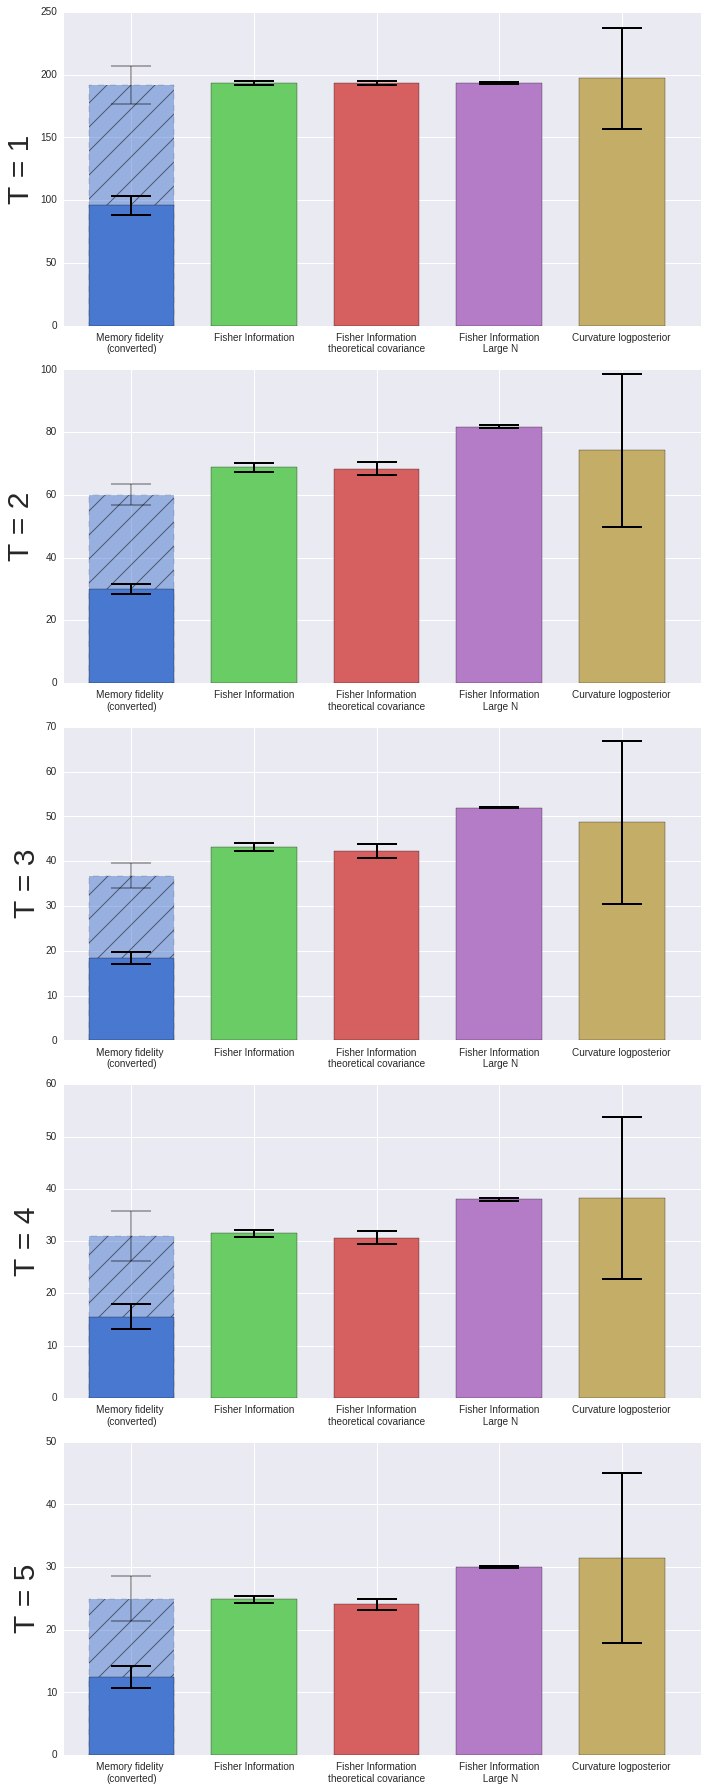

In [79]:
values_to_plot = [('Memory fidelity \n(converted)', 'mem_fidelity_as_variance'),
                  ('Fisher Information', 'result_FI_rc_theo'),
                  ('Fisher Information\ntheoretical covariance', 'result_FI_rc_theocov'),
                  ('Fisher Information\n Large N', 'result_FI_rc_theo_largeN'),
                  ('Curvature logposterior', 'result_FI_rc_curv')
               ]

f, axes = plt.subplots(T_space.size, 1, figsize=(10, 5*T_space.size))


for T_i, T in enumerate(T_space):
    values_dict = extract_fisherinfo_values(all_experiment_launcher[T_i], values_to_plot)
    bars_fisherinfo_comparison(values_dict['mean'], values_dict['std'], values_dict['names'], ax=axes[T_i])
    
    axes[T_i].set_ylabel("T = %d" % T, fontsize=30)

## Mixed code

In [80]:
arguments_dict['code_type'] = 'mixed'
arguments_dict['ratio_conj'] = 0.8
arguments_dict['num_repetitions'] = 1

all_experiment_launcher_mixed = []
for T in progress.ProgressDisplay(T_space):
    print "==== Doing T=%d ====" % T
    arguments_dict['T'] = T
    
    with io.capture_output(display=False, stdout=True) as captured:
        all_experiment_launcher_mixed.append(ExperimentLauncher(run=True, arguments_dict=arguments_dict))


[0%] --
==== Doing T=1 ====


NotImplementedError: Fisher information not defined for population type mixed

In [ ]:
values_to_plot = [('Memory fidelity \n(converted)', 'mem_fidelity_as_variance'),
                  ('Fisher Information', 'result_FI_rc_theo'),
                  ('Fisher Information\ntheoretical covariance', 'result_FI_rc_theocov'),
                  ('Fisher Information\n Large N', 'result_FI_rc_theo_largeN'),
                  ('Curvature logposterior', 'result_FI_rc_curv')
               ]

f, axes = plt.subplots(T_space.size, 1, figsize=(10, 5*T_space.size))


for T_i, T in enumerate(T_space):
    values_dict = extract_fisherinfo_values(all_experiment_launcher_mixed[T_i], values_to_plot)
    bars_fisherinfo_comparison(values_dict['mean'], values_dict['std'], values_dict['names'], ax=axes[T_i])
    
    axes[T_i].set_ylabel("T = %d" % T, fontsize=30)

In [84]:
rn = sampler.random_network

In [170]:
resps = rn.collect_network_responses(num_samples=50000)

[100%] 55s                                                                    


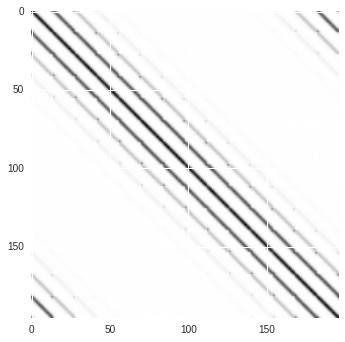

In [196]:
measured_cov = np.cov(resps.T)
plt.imshow(measured_cov)

In [197]:
N = measured_cov.shape[0]
measured_cov_rollback = np.zeros((N, N))
for roll_amount in xrange(N):
    measured_cov_rollback[roll_amount] = np.roll(measured_cov[roll_amount], -roll_amount)

    circulant_dist = np.sum(np.diff(measured_cov_rollback, axis=0)**2.)

print "Circulant: MSE %f" % circulant_dist

Circulant: MSE 0.002542


In [198]:
circ_c = np.roll(sp.linalg.circulant(measured_cov[N/2-1]), N/2-1, axis=1)

In [199]:
measured_cov /= measured_cov.max()
circ_c /= circ_c.max()

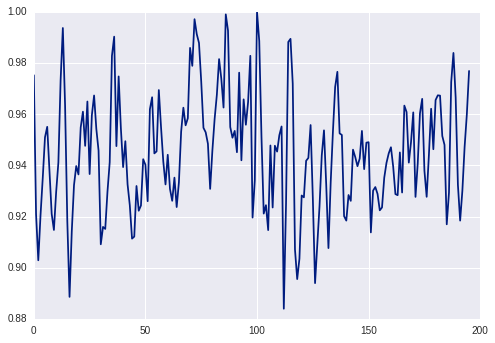

In [200]:
plt.plot(np.diag(measured_cov))

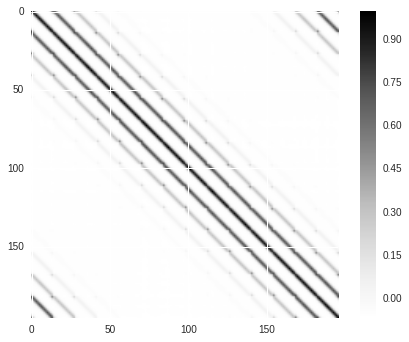

In [201]:
plt.imshow(measured_cov)
plt.colorbar()

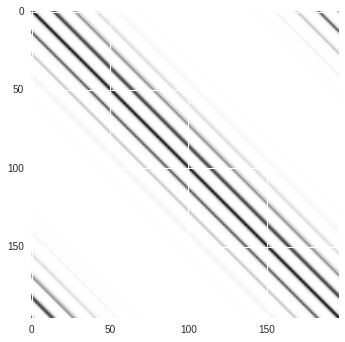

In [202]:
plt.imshow(circ_c)

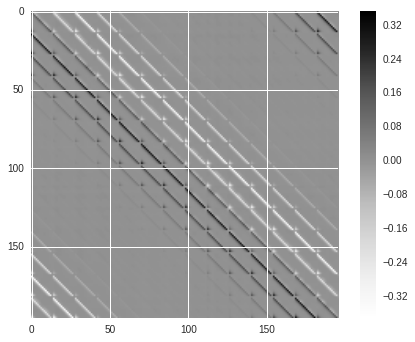

In [203]:
plt.imshow((measured_cov - circ_c))
plt.colorbar()

In [204]:
measured_cov

array([[ 0.97522904,  0.71628541,  0.28565241, ...,  0.01793433,
         0.22159401,  0.55570178],
       [ 0.71628541,  0.92087164,  0.67911702, ..., -0.0460124 ,
         0.01929357,  0.21911415],
       [ 0.28565241,  0.67911702,  0.90288337, ..., -0.05857498,
        -0.0460088 ,  0.01756659],
       ..., 
       [ 0.01793433, -0.0460124 , -0.05857498, ...,  0.94714595,
         0.7152507 ,  0.29771196],
       [ 0.22159401,  0.01929357, -0.0460088 , ...,  0.7152507 ,
         0.95992778,  0.73114917],
       [ 0.55570178,  0.21911415,  0.01756659, ...,  0.29771196,
         0.73114917,  0.97690178]])

In [205]:
circ_c

array([[ 1.        ,  0.74592071,  0.30392778, ...,  0.01178517,
         0.21377478,  0.55287559],
       [ 0.55287559,  1.        ,  0.74592071, ..., -0.05246667,
         0.01178517,  0.21377478],
       [ 0.21377478,  0.55287559,  1.        , ..., -0.06412732,
        -0.05246667,  0.01178517],
       ..., 
       [ 0.03999876, -0.04493287, -0.0630612 , ...,  1.        ,
         0.74592071,  0.30392778],
       [ 0.30392778,  0.03999876, -0.04493287, ...,  0.55287559,
         1.        ,  0.74592071],
       [ 0.74592071,  0.30392778,  0.03999876, ...,  0.21377478,
         0.55287559,  1.        ]])

In [207]:
c_tilde = np.fft.fft(measured_cov[0])

In [212]:
freqs = np.fft.fftfreq(N)
mu_tilde = np.fft.fft(rn.get_derivative_network_response())

In [215]:
freqs

array([ 0.        ,  0.00510204,  0.01020408,  0.01530612,  0.02040816,
        0.0255102 ,  0.03061224,  0.03571429,  0.04081633,  0.04591837,
        0.05102041,  0.05612245,  0.06122449,  0.06632653,  0.07142857,
        0.07653061,  0.08163265,  0.08673469,  0.09183673,  0.09693878,
        0.10204082,  0.10714286,  0.1122449 ,  0.11734694,  0.12244898,
        0.12755102,  0.13265306,  0.1377551 ,  0.14285714,  0.14795918,
        0.15306122,  0.15816327,  0.16326531,  0.16836735,  0.17346939,
        0.17857143,  0.18367347,  0.18877551,  0.19387755,  0.19897959,
        0.20408163,  0.20918367,  0.21428571,  0.21938776,  0.2244898 ,
        0.22959184,  0.23469388,  0.23979592,  0.24489796,  0.25      ,
        0.25510204,  0.26020408,  0.26530612,  0.27040816,  0.2755102 ,
        0.28061224,  0.28571429,  0.29081633,  0.29591837,  0.30102041,
        0.30612245,  0.31122449,  0.31632653,  0.32142857,  0.32653061,
        0.33163265,  0.33673469,  0.34183673,  0.34693878,  0.35